In [10]:
import os
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import yaml
from loguru import logger
from tqdm import tqdm
import natsort
import glob
import cv2
from PIL import Image
from data.dataset import Sentinel2TCIDataset, Sentinel2Dataset
from data.loader import define_loaders
from model_zoo.models import define_model
from training.metrics import MultiSpectralMetrics, avg_metric_bands
from utils.torch import count_parameters, load_model_weights, seed_everything
from utils.utils import load_config
from utils.wandb_logger import WandbLogger
from training.losses import WeightedMSELoss

In [21]:
def prepare_paths(path_dir):


    df_input = pd.read_csv(f"{path_dir}/input.csv")
    df_output = pd.read_csv(f"{path_dir}/target.csv")

    df_input["path"] = df_input["Name"].apply(lambda x: os.path.join(path_dir, "input", os.path.basename(x).replace(".SAFE","")))
    df_output["path"] = df_output["Name"].apply(lambda x: os.path.join(path_dir, "target", os.path.basename(x).replace(".SAFE","")))

    return df_input, df_output


def prepare_data(config):
    base_dir = config['DATASET']['base_dir']
    version = config['DATASET']['version']
    resize = config['TRAINING']['resize']


    TRAIN_DIR = f"/mnt/disk/dataset/sentinel-ai-processor/{version}/train/"
    VAL_DIR = f"/mnt/disk/dataset/sentinel-ai-processor/{version}/val/"
    TEST_DIR = f"/mnt/disk/dataset/sentinel-ai-processor/{version}/test/"

    df_train_input, df_train_output =  prepare_paths(TRAIN_DIR)
    df_val_input, df_val_output =  prepare_paths(VAL_DIR)
    df_test_input, df_test_output =  prepare_paths(TEST_DIR)

    logger.info(f"Number of training samples: {len(df_train_input)}")
    logger.info(f"Number of validation samples: {len(df_val_input)}")
    logger.info(f"Number of test samples: {len(df_test_input)}")

    train_dataset = Sentinel2Dataset(df_x=df_train_input, df_y=df_train_output, train=True, augmentation=False, img_size=resize)
    val_dataset = Sentinel2Dataset(df_x=df_val_input, df_y=df_val_output, train=True, augmentation=False, img_size=resize)
    test_dataset = Sentinel2Dataset(df_x=df_test_input, df_y=df_test_output, train=True, augmentation=False, img_size=resize)



    train_loader, val_loader = define_loaders(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        train=True,
        batch_size=config['TRAINING']['batch_size'],
        num_workers=config['TRAINING']['num_workers'])

    test_loader = define_loaders(
        train_dataset=test_dataset,
        val_dataset=None,
        train=False,
        batch_size=config['TRAINING']['batch_size'],
        num_workers=config['TRAINING']['num_workers'])

    return train_loader, val_loader, test_loader


In [22]:
config = load_config(config_path="cfg/config.yaml")
version = "V3"
resize = 1024
TEST_DIR = f"/mnt/disk/dataset/sentinel-ai-processor/{version}/test/"
df_input, df_output = prepare_paths(TEST_DIR)

In [23]:
def normalize(data_array):
    """
    Normalize each band in a multi-band image array to the range [0, 1].

    For each band, pixels with values > 0 are considered valid.
    Normalization is done based on the min and max of valid pixels only.
    Invalid pixels (≤ 0) are set to 0 after normalization.

    Parameters
    ----------
    data_array : np.ndarray
        Input image array of shape (H, W, C), where H = height, W = width, C = number of bands.

    Returns
    -------
    normalized_data : np.ndarray
        Normalized data array with values in [0, 1], same shape as input.
    valid_masks : np.ndarray
        Boolean mask array indicating valid pixels, shape (H, W, C).
    norm_params : list of tuple
        List of (min, max) values used for normalization per band.
    """

    normalized_data = []
    valid_masks = []
    norm_params = []
    for i in range(data_array.shape[2]):
        band_data = data_array[:, :, i]
        valid_mask = (band_data > 0)
        valid_pixels = band_data[valid_mask]
        min_val = np.min(valid_pixels)
        max_val = np.max(valid_pixels)
        norm_params.append((min_val, max_val))

        result = band_data.copy().astype(np.float32)
        result[valid_mask] = (valid_pixels - min_val) / (max_val - min_val)
        result[~valid_mask] = 0.0
        normalized_data.append(result)
        valid_masks.append(valid_mask)
    return np.dstack(normalized_data), np.dstack(valid_masks), norm_params

def denormalize(norm_data, valid_masks, norm_params):
    """
    Denormalize a normalized multi-band image back to its original value range and convert to integers.

    Parameters
    ----------
    norm_data : ndarray
        A 3D NumPy array of normalized data (H, W, C), where values are in the range [0, 1].

    valid_masks : ndarray
        Boolean mask array of shape (H, W, C) indicating which pixels were originally valid.

    norm_params : list of tuples
        List of (min, max) values per band used during normalization.

    Returns
    -------
    restored_data : ndarray
        Denormalized image array of shape (H, W, C) with dtype uint16.
    """

    restored_data = []
    for i in range(norm_data.shape[2]):
        band = norm_data[:, :, i]
        valid_mask = valid_masks[:, :, i]
        min_val, max_val = norm_params[i]

        restored_band = band.copy()
        restored_band[valid_mask] = band[valid_mask] * (max_val - min_val) + min_val

        restored_band[~valid_mask] = 0.0
        restored_data.append(np.round(restored_band).astype(np.uint16))
    return np.dstack(restored_data)

def read_images(product_paths):
    """
    Read and stack a list of grayscale image files into a multi-band image.

    Parameters
    ----------
    product_paths : list of str
        List of file paths to the images to read.

    Returns
    -------
    images : ndarray
        A 3D NumPy array of shape (H, W, C), where each image is treated as one band (C channels).
    """

    images = []
    for path in product_paths:
        data = Image.open(path)
        data = np.array(data)
        images.append(data)
    # H x W x C
    images = np.dstack(images)
    return images

In [39]:
random_index = np.random.choice(df_input.index)
random_row = df_input.loc[random_index]

x_paths = natsort.natsorted(glob.glob(os.path.join(df_input["path"][random_index], "*.png")))
y_paths = natsort.natsorted(glob.glob(os.path.join(df_output["path"][random_index], "*.png")))

x_data = read_images(x_paths)
y_data = read_images(y_paths)

x_data_norm, x_valid_masks, x_norm_params = normalize(x_data)
y_data_norm, y_valid_masks, y_norm_params = normalize(y_data)

new_x_data = denormalize(x_data_norm, x_valid_masks, x_norm_params)
new_y_data = denormalize(y_data_norm, y_valid_masks, y_norm_params)

In [29]:
x = x_data/15000
y = y_data/15000

In [30]:
x.min(), x.max(), x.mean(), x.std()

(0.17566666666666667,
 1.8700666666666668,
 0.33114022374842794,
 0.1107793615294789)

In [346]:
y.min(), y.max(), y.mean(), y.std()

(0.0, 3.8224, 0.17187661015059663, 0.5131447801560758)

In [347]:
y_data.min(), y_data.max(), y_data.mean(), y_data.std()

(0, 38224, 1718.766101505967, 5131.44780156076)

In [20]:
x_data.min(), x_data.max(), x_data.mean(), x_data.std()

(tensor(2708.), tensor(34291.), tensor(9142.5928), tensor(4504.1060))

In [355]:
from tqdm import tqdm

l2a_max = []
l2a_min = []

l1c_max = []
l1c_min = []

for i in tqdm(range(len(df_input)), desc="Processing images"):
    x_paths = natsort.natsorted(glob.glob(os.path.join(df_input["path"][i], "*.png")))
    y_paths = natsort.natsorted(glob.glob(os.path.join(df_output["path"][i], "*.png")))

    x_data = read_images(x_paths)
    y_data = read_images(y_paths)

    x_data = x_data/10000
    y_data = y_data/10000

    valid_mask = (x_data > 0)
    valid_pixels = x_data[valid_mask]

    l2a_max.append(x_data.max())
    l2a_min.append(valid_pixels.min())

    valid_mask = (y_data > 0)
    valid_pixels = y_data[valid_mask]

    l1c_max.append(y_data.max())
    l1c_min.append(valid_pixels.min())

Processing images: 100%|██████████| 530/530 [03:04<00:00,  2.87it/s]


NameError: name 'l1c_min' is not defined

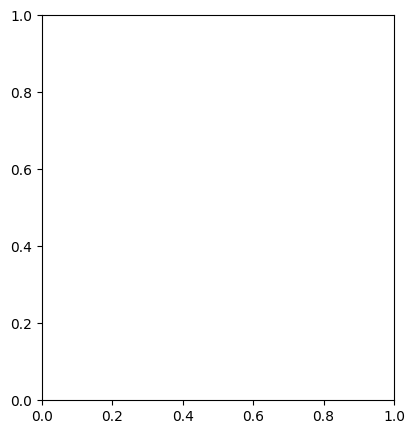

In [17]:
#plot histogram max and min
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(l1c_min, bins=100, alpha=0.5, label='L1C Min')

plt.hist(l2a_min, bins=100, alpha=0.5, label='L2A Min')
plt.title('L1C / L2A Min Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(l2a_max, bins=100, alpha=0.5, label='L2A Max')
plt.hist(l1c_max, bins=100, alpha=0.5, label='L1C Max')
plt.title('L1C / L2A Max Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
import segmentation_models_pytorch as smp


In [51]:
model = smp.Unet(
    encoder_name="timm-efficientnet-b2",  # choose encoder, e.g. mobilenet_v2, efficientnet-b7, resnet50, etc.
    encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,  # model output channels (number of classes in your dataset)
    activation=None,  # activation function (softmax, sigmoid, etc.)
)

In [8]:
import torch



In [40]:
x_data = cv2.resize(x_data, (1024, 1024), interpolation=cv2.INTER_AREA)
x_data = torch.from_numpy(x_data).float()
x_data = torch.permute(x_data, (2, 0, 1))  # HWC to CHW

In [41]:
x_data = x_data/ 10000
x_data = x_data.unsqueeze(0)  # Add batch dimension

In [42]:
x_data.shape

torch.Size([1, 3, 1024, 1024])

In [43]:
x_data.min()

tensor(0.)

In [52]:
outputs = model(x_data)

In [53]:
outputs.max(), outputs.min(), outputs.mean(), outputs.std()

(tensor(15.1406, grad_fn=<MaxBackward1>),
 tensor(-21.2954, grad_fn=<MinBackward1>),
 tensor(-0.3354, grad_fn=<MeanBackward0>),
 tensor(1.0282, grad_fn=<StdBackward0>))